In [1]:
# set up
WORKING_DIR = '/home/elliott/Dropbox/_Ash_Teaching/2018-09 - Bocconi - Text Data and ML/code'
import os
os.chdir(WORKING_DIR)
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')


In [2]:
# our first dataset
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',
                             max_features=4)
X = vectorizer.fit_transform(df1['snippet'])
words = vectorizer.get_feature_names()
print(words)
X

['court', 'death', 'penalty', 'quot']


<32567x4 sparse matrix of type '<class 'numpy.int64'>'
	with 82110 stored elements in Compressed Sparse Row format>

In [3]:
X = X.todense()
X = X / X.sum(axis=1) # counts to frequencies
for i, word in enumerate(words):
    column = X[:,i]
    df1['x_'+word] = column
df1.head()

,court_id,author_id,state,year,dateFiled,citeCount,snippet,x_court,x_death,x_penalty,x_quot
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,N.J. ( )\n A. d \nIN RE WAIVER OF DEATH PE...,0.230769,0.384615,0.384615,0.000000
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,"whether the death penalty is, per se, unconsti...",0.000000,0.473684,0.473684,0.052632
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,# ;s contention that the assessment of the dea...,0.000000,0.454545,0.545455,0.000000
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,. d ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...,0.000000,0.500000,0.500000,0.000000
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume the district attorney orally waived the...,0.000000,0.428571,0.428571,0.142857


In [4]:
# inspecting data
import numpy as np
df1['logcites'] = np.log(1+df1['citeCount'])
features = ['x_'+x for x in words]
cites_features = ['logcites'] + features
df2 = df1[cites_features]
corr_matrix = df2.corr()
corr_matrix['logcites'].sort_values(ascending=False)

logcites     1.000000
x_death      0.041527
x_penalty    0.019063
x_court     -0.004189
x_quot      -0.034363
Name: logcites, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57c0eb54a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f57c054b748>]], dtype=object)

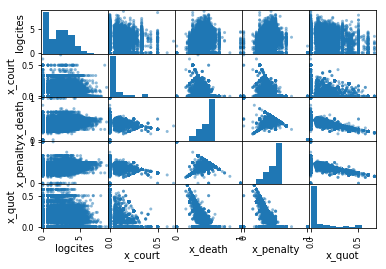

In [7]:
from pandas.plotting import scatter_matrix
scatter_matrix(df2)

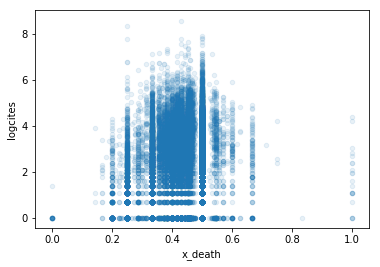

In [6]:
df2.plot(kind='scatter', x='x_death', y='logcites', alpha = 0.1)

In [8]:
# create a test set 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df2, test_size=0.2)

In [9]:
# our first machine learning model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
Xtrain = train[features]
Ytrain = train['logcites']
lin_reg.fit(Xtrain, Ytrain)
lin_reg.coef_

array([  1.29659865e+14,   1.29659865e+14,   1.29659865e+14,
         1.29659865e+14])

In [10]:
# in-sample performance
from sklearn.metrics import mean_squared_error
Ytrain_pred = lin_reg.predict(Xtrain)        
train_mse = mean_squared_error(Ytrain,Ytrain_pred)
train_mse

2.6534439387628659

In [11]:
# out-of-sample performance
Xtest = test[features]
Ytest = test['logcites']
Ytest_pred = lin_reg.predict(Xtest)        
test_mse = mean_squared_error(Ytest,Ytest_pred)
test_mse

2.5744760227755288

In [12]:
# missing values
judge = df1['author_id']
judge.fillna(0,inplace=True)

In [13]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df2)
df2 = pd.DataFrame(X,columns=df2.columns)

In [14]:
# Encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
judge_fes = encoder.fit_transform(judge.values.reshape(-1,1))
judge_ids = ['j_'+str(x) for x in range(len(judge.unique()))]
judge_fes = pd.DataFrame(judge_fes.todense(),columns=judge_ids)
df1 = pd.concat([df1,judge_fes],axis=1)
train, test = train_test_split(df1, test_size=0.2)
df1['anycites'] = df1['citeCount'] > 0

In [15]:
# Cross-validation
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg,
                         df1[features],
                         df1['anycites'],
                         cv=3,
                         n_jobs=-1)
scores.mean()

-11.830010282783258

In [16]:
# Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [3, 10, 30],
              'max_features': [2, 4],
              'bootstrap': [True, False]}

grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=3)              
grid_search.fit(df1[features],df1['logcites'])

grid_search.best_params_
grid_search.best_score_


-2.7571790161156509

In [17]:
from sklearn.model_selection import RandomizedSearchCV
rand_search = RandomizedSearchCV(forest_reg, param_grid, cv=3)              
rand_search.fit(df1[features],df1['logcites'])

rand_search.best_params_

{'n_estimators': 10, 'max_features': 2, 'bootstrap': True}

In [18]:
# Saving and loading
from sklearn.externals import joblib
joblib.dump(forest_reg,'forest_reg.pkl')
forest_reg = joblib.load('forest_reg.pkl')